In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
import gpzoo
from gpzoo.kernels import NSF_RBF
from gpzoo.gp import GaussianPrior, SVGP, VNNGP
from gpzoo.likelihoods import PNMF, NSF2, Hybrid_NSF2
from gpzoo.utilities import train_hybrid, train_hybrid_batched, anndata_to_train_val, plot_factors, rescale_spatial_coords, add_jitter, init_softplus
import squidpy as sq
import numpy as np
from sklearn.decomposition import NMF
import scanpy as sc
import random

from gpzoo.utilities import regularized_nmf, dims_autocorr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import pickle

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):

    max_val = np.percentile(factors, 95)
    min_val = np.percentile(factors, 5)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
        
    for i in range(L):
        
        
        curr_ax = ax[i//5, i%5]
        
        
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [3]:
adata = sq.datasets.slideseqv2()
adata = adata.raw.to_adata()

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


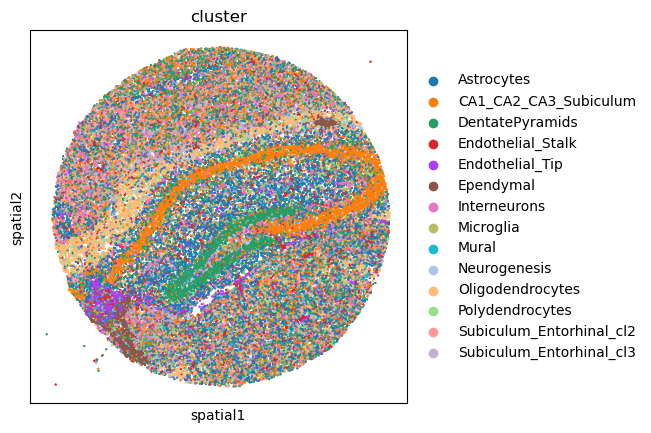

In [4]:
sq.pl.spatial_scatter(adata, color="cluster", size=1, shape=None);


<Axes: >

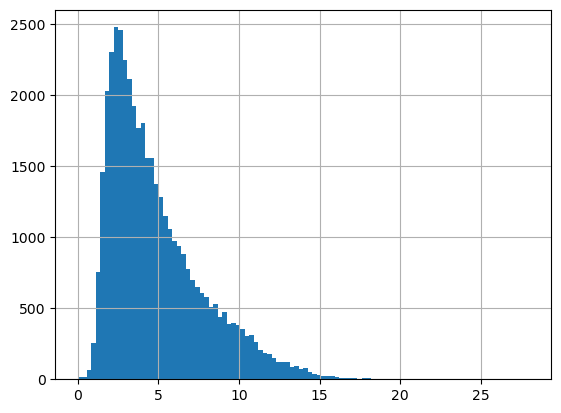

In [5]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata.obs.pct_counts_mt.hist(bins=100)


In [6]:
adata = adata[adata.obs.pct_counts_mt < 20] #from 53K to 45K
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=10)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [8]:
Dtr, Dval = anndata_to_train_val(adata, sz="scanpy")

In [9]:
Y = Dtr['Y'].T
Y = Y[~adata.var.MT]
X = Dtr['X']*50
V = Dtr['sz']

In [10]:
Y.shape

(17702, 39694)

In [11]:
factors, loadings = regularized_nmf(Y.T, L=15, shrinkage=0.3, max_iter = 1000, solver='mu', init='nndsvdar', beta_loss='kullback-leibler', random_state=420)

In [12]:
moran_idx, moranI = dims_autocorr(np.exp(factors), X)

here_andata


In [13]:
moranI

array([0.85309242, 0.83724045, 0.81369781, 0.76539577, 0.71483813,
       0.61274662, 0.61126043, 0.58948405, 0.48651951, 0.45077694,
       0.33274251, 0.32581142, 0.23940599, 0.22667668, 0.21702887])

In [14]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

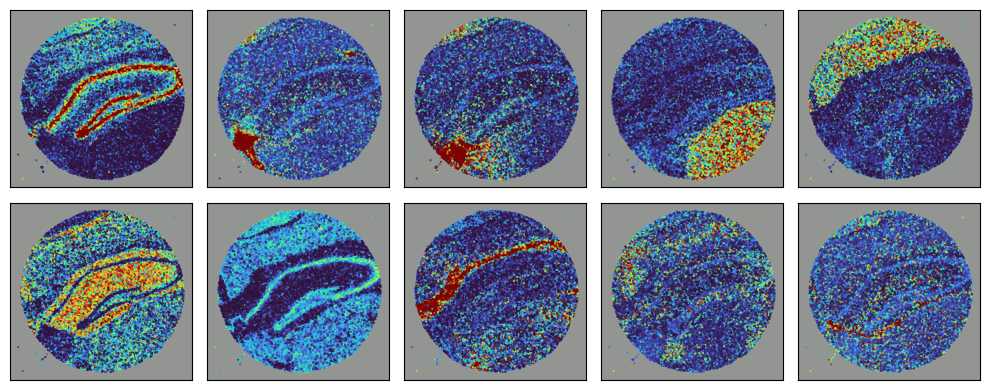

In [15]:
plot_factors(np.exp(factors.T), X, moran_idx=moran_idx[0:10], ax=None, size=2, s=0.2, alpha=0.9)

In [16]:
X = torch.tensor(X).type(torch.float)
Y = torch.tensor(Y).type(torch.float)

In [32]:
def build_model(Y, M=1000, L=10):
    

    
    idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)

    Z = nn.Parameter(X[idx].clone().detach())
    
    kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=2.5)
    gp = SVGP(kernel, M=M, jitter=1e-2)
    Kzx = kernel.forward(Z, X)
    Kxz = torch.transpose(Kzx, -2, -1)
    Kzz = kernel.forward(Z, Z)

    

    all_factors = torch.tensor(factors_ordered.T)[:L, :, None].type(torch.float)
    L1 = torch.linalg.cholesky(add_jitter(Kzx@Kxz, 1e-4))
    

    solved1 = torch.cholesky_solve(Kzx@all_factors, L1)
    print('solved1 shape:', solved1.shape)
    
    
    mu = Kzz@solved1

    print('here')
    
    
    # gp.mu = nn.Parameter(torch.randn((L, M)).type(torch.float))
    
    gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float)
    
    Lu = 1e-2*torch.eye(M).expand(L, M, M)
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = nn.Parameter(Z, requires_grad=False)

    model = NSF2(gp, Y, L=L)

    model.W = nn.Parameter(torch.tensor(init_softplus(loadings_ordered)[:, :L]).type(torch.float)) 

    model.V = nn.Parameter(torch.squeeze(torch.tensor(init_softplus(V)).type(torch.float))) 
    
    model.to(device)
    return model

In [33]:
model = build_model(Y, M=3000)

solved1 shape: torch.Size([10, 3000, 1])
here


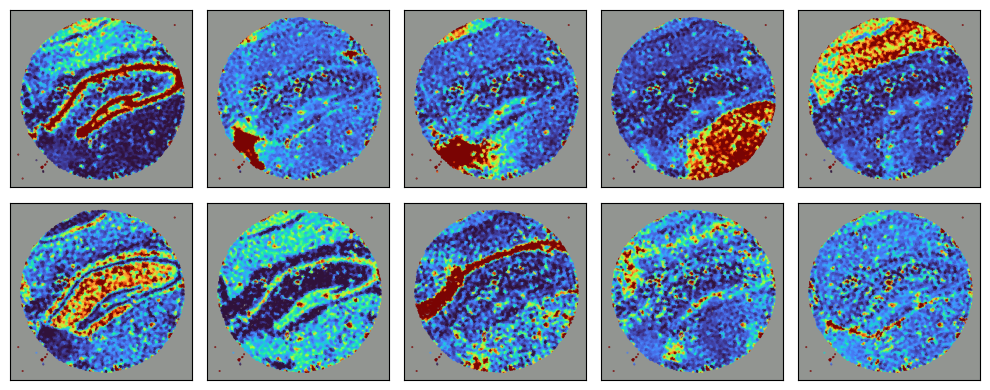

In [34]:
model.cpu()
qF, _, _ = model.prior(X)
mean = torch.exp(qF.mean).detach().numpy()
plot_factors(mean, X, moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)

In [35]:
X_train = X.to(device)
Y_train = Y.to(device)

In [36]:
def model_grads(model):
    model.prior.kernel.sigma.requires_grad = False

    model.prior.kernel.lengthscale.requires_grad = False
    model.prior.Z.requires_grad=False
    model.prior.mu.requires_grad=False
    model.prior.Lu.requires_grad=True
    model.W.requires_grad=True
    
    model.V.requires_grad=False

In [37]:
model_grads(model)

In [38]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [39]:
def train_batched(model, optimizer, X, y, device, steps=200, E=20, batch_size=1000, **kwargs):
    losses = []
    
    means = []
    scales = []
    idxs = []
    
    for it in tqdm(range(steps)):
        
        idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=batch_size, replacement=False)
        
        
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward_batched(X=X, idx=idx, E=E, **kwargs)

        logpY = y[:, idx]*torch.log(pY.rate) - pY.rate

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        
        loss = -ELBO
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if (it%10)==0:
            idxs.append(idx.detach().cpu().numpy())
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales, idxs

In [40]:
steps = 6000
model.to(device)

NSF2(
  (prior): SVGP(
    (kernel): NSF_RBF()
  )
)

In [41]:
model.prior.jitter=1e-2

In [ ]:
losses, means, scales, idxs = train_batched(model, optimizer, X_train, Y_train, device, steps=steps, E=3, batch_size=5000)

  0%|          | 0/6000 [00:00<?, ?it/s]

In [ ]:
plt.plot(losses)

In [ ]:
def model_grads(model):
    model.prior.kernel.sigma.requires_grad = False

    model.prior.kernel.lengthscale.requires_grad = False
    model.prior.Z.requires_grad=False
    model.prior.mu.requires_grad=True
    model.prior.Lu.requires_grad=True
    model.W.requires_grad=True
    
    model.V.requires_grad=False


model_grads(model)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
steps = 12000
model.to(device)
losses, means, scales, idxs = train_batched(model, optimizer, X_train, Y_train, device, steps=steps, E=3, batch_size=5000)
plt.plot(losses)


In [ ]:
model.prior.kernel.lengthscale

In [ ]:
model.prior.Lu.min()

In [ ]:
plot_factors(means[0], X[idxs[0]], moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)
plot_factors(means[-1], X[idxs[-1]], moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)


In [25]:
# model.cpu()
# Xtest = torch.cartesian_prod(torch.linspace(-2, 2, 34), torch.linspace(-2, 2, 34), )
# qF1, _, _ = model1.sf.prior(Xtest)
# qF2, _ = model1.cf.prior()
# means1_test = torch.exp(qF1.mean).detach().numpy()
# means2_test = torch.exp(qF2.mean).detach().numpy()

In [26]:
# plot_factors(means1_test, Xtest, moran_idx=None, ax=None, size=2, s=5, alpha=1)

hi 0
hi 0
hi 1
hi 2
hi 3
hi 4
hi 5
hi 6
hi 7
hi 8
hi 9
hi 10
hi 11
hi 12
hi 13
hi 14
hi 15
hi 16
hi 17
hi 18
hi 19
hi 20
hi 21
hi 22
hi 23
hi 24
hi 25
hi 26
hi 27
hi 28
hi 29
hi 30
hi 31
hi 32
hi 33
hi 34
hi 35
hi 36
hi 37
hi 38
hi 39
hi 40
hi 41
hi 42
hi 43
hi 44
hi 45
hi 46
hi 47
hi 48
hi 49
hi 50
hi 51
hi 52
hi 53
hi 54
hi 55
hi 56
hi 57
hi 58
hi 59
hi 60
hi 61
hi 62
hi 63
hi 64
hi 65
hi 66
hi 67
hi 68
hi 69
hi 70
hi 71
hi 72
hi 73
hi 74
hi 75
hi 76
hi 77
hi 78
hi 79
hi 80
hi 81
hi 82
hi 83
hi 84
hi 85
hi 86
hi 87
hi 88
hi 89
hi 90
hi 91
hi 92
hi 93
hi 94
hi 95
hi 96
hi 97
hi 98
hi 99
hi 100
hi 101
hi 102
hi 103
hi 104
hi 105
hi 106
hi 107
hi 108
hi 109
hi 110
hi 111
hi 112
hi 113
hi 114
hi 115
hi 116
hi 117
hi 118
hi 119
hi 120
hi 121
hi 122
hi 123
hi 124
hi 125
hi 126
hi 127
hi 128
hi 129
hi 130
hi 131
hi 132
hi 133
hi 134
hi 135
hi 136
hi 137
hi 138
hi 139
hi 140
hi 141
hi 142
hi 143
hi 144
hi 145
hi 146
hi 147
hi 148
hi 149
hi 150
hi 151
hi 152
hi 153
hi 154
hi 155
hi 156
hi 157

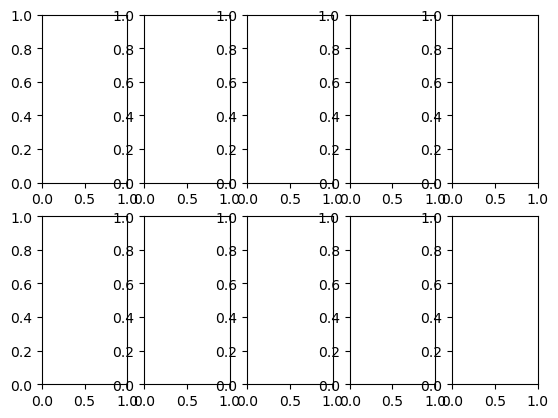

In [34]:
size=2
fig, ax = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)


def update(iteration):
    for element in ax:
        for element in element:
            element.cla()
        
    curr_factor = means[iteration]

    
    
    plot_factors(curr_factor, X, ax=ax, size=2, s=0.6, alpha=1)

#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)


anim = FuncAnimation(fig, update, frames=np.arange(0, 600, 1), interval=100)
plt.close()
# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("visium_vnngp.mp4", fps=60, dpi=100)